In [4]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/home/roy/AtomCraft/install_release/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_power_flux_fun
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain, save_gs_mesh

In [5]:
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2

# Mesh Generation

In [3]:
plasma_dx = 0.01
coil_dx = 0.01
vv_dx = 0.01
vac_dx = 0.06

In [4]:
geom = {
    "limiter": [],
    "vv": {
        "eta": 6.9e-7
    },
    "coils": []
}

In [5]:
# * Create Limiter and VV
limiter = []

RWalls = [0.160, 0.1761, 0.2200, 0.280, 0.3400, 0.3839, 0.40, 0.3839, 0.3400, 0.280, 0.2200, 0.1761, 0.160]
ZWalls = [0.000, 0.0600, 0.1039, 0.120, 0.1039, 0.0600, 0.00, -0.0600, -0.1039, -0.120, -0.1039, -0.0600, 0.000]
for R, Z in zip(RWalls, ZWalls):
    limiter.append([R, Z])
    
geom["limiter"] = limiter
geom["vv"]["vv_inner_cntr"] = limiter
geom["vv"]["vv_outer_cntr"] = limiter
geom["vv"]["shell_cntr"] = limiter

In [20]:
# Create Coils
geom["coils"] = {
    "VF1_U": {
        "rc": 0.15,
        "zc": 0.35,
        "w": 0.01905,
        "h": 0.060325,
        "nturns": 1
    },
    "VF1_L": {
        "rc": 0.15,
        "zc": -0.35,
        "w": 0.01905,
        "h": 0.060325,
        "nturns": 1
    },
    "VF2_U": {
        "rc": 0.30,
        "zc": 0.275,
        "w": 0.01905,
        "h": 0.060325,
        "nturns": 1
    },
    "VF2_L": {
        "rc": 0.30,
        "zc": -0.275,
        "w": 0.01905,
        "h": 0.060325,
        "nturns": 1
    },
    "VF3_U": {
        "rc": 0.45,
        "zc": 0.10,
        "w": 0.01905,
        "h": 0.060325,
        "nturns": 1
    },
    "VF3_L": {
        "rc": 0.45,
        "zc": -0.10,
        "w": 0.01905,
        "h": 0.060325,
        "nturns": 1
    },
}

In [21]:
# Create a G-S domain
gs_mesh = gs_Domain()

# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')        # Define the bounding region
gs_mesh.define_region('plasma',plasma_dx,'plasma')    # Define the plasma region and resolution
gs_mesh.define_region('vacuum',vac_dx,'vacuum')       # Define the vacuum inside the VV
gs_mesh.define_region('shell',vv_dx,'conductor',eta=geom['vv']['eta'])  # Define the shells
gs_mesh.define_region('vv',vv_dx,'conductor',eta=geom['vv']['eta'])      # Define the VV

# Define each of the PF coils
for key, coil in geom['coils'].items():
    gs_mesh.define_region(key,coil_dx,'coil',nTurns=coil['nturns'],coil_set=key[:2])

In [22]:
# Define geometry
gs_mesh.add_polygon(geom['limiter'][:-1], 'plasma', parent_name='vacuum')
gs_mesh.add_polygon(geom['vv']['shell_cntr'], 'shell', parent_name='vacuum')
gs_mesh.add_annulus(geom['vv']['vv_inner_cntr'], 'vacuum', geom['vv']['vv_outer_cntr'], 'vv', parent_name='air')

# Define the shape of the PF coils
for key, coil in geom['coils'].items():
    gs_mesh.add_rectangle(coil['rc'], coil['zc'], coil['w'], coil['h'], key, parent_name='air')
    

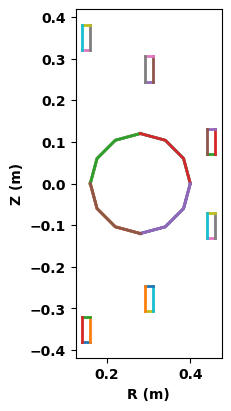

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
gs_mesh.plot_topology(fig, ax)

In [24]:
# Save geom
with open("mesh.json", "w") as mesh:
    json.dump(geom, mesh)

In [25]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 204
  # of unique segments  = 32
Generating mesh:
  # of points  = 1145
  # of cells   = 2240
  # of regions = 11


In [27]:
save_gs_mesh(mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict,'mesh.h5')

# Compute Equilibria

In [6]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  10
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



In [7]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0=0.125*0.28) # F0 = B0 * R0


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  5.031E-01
    # of points  =    1145
    # of edges   =    3384
    # of cells   =    2240
    # of boundary points =      48
    # of boundary edges  =      48
    # of boundary cells  =      48
  Resolution statistics:
    hmin =  6.224E-03
    hrms =  2.442E-02
    hmax =  7.711E-02
  Surface grounded at vertex     173


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    4.5624700000000001E-004


In [7]:
# Need to check the bounds for this
# coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
# for name, coil in mygs.coil_sets.items():
#     if name.startswith('OH'):
#         bounds = [-2.00E+04,2.00E+04]
#     elif name.startswith('VF'):
#         bounds = [-1.50E+04,4.20E+04]
#     elif name.startswith('SH'):
#         bounds = [-1.50E+04,1.50E+04]
#     coil_bounds[coil['id'],:] = np.array(bounds)
# 
# mygs.set_coil_bounds(coil_bounds)

In [8]:
Ip_target = 10e3 # Amps

mygs.set_targets(Ip=Ip_target, Ip_ratio=0.02)

In [9]:
isoflux_pts = np.array([
    [0.3, 0.24],
    [0.3, -0.24]
])

mygs.set_isoflux(isoflux_pts)

In [10]:
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E-1*np.ones((mygs.ncoils+1,), dtype=np.float64)
coil_reg_targets = np.zeros((mygs.ncoils+1,), dtype=np.float64)

# Force shaping coil to 0
# coil_reg_weights[mygs.coil_sets['SH']['id']] = 1.E3

# Set OH current to -8 kA
# coil_reg_targets[mygs.coil_sets['OH']['id']] = -8.E3
# coil_reg_weights[mygs.coil_sets['OH']['id']] = 1.E3

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

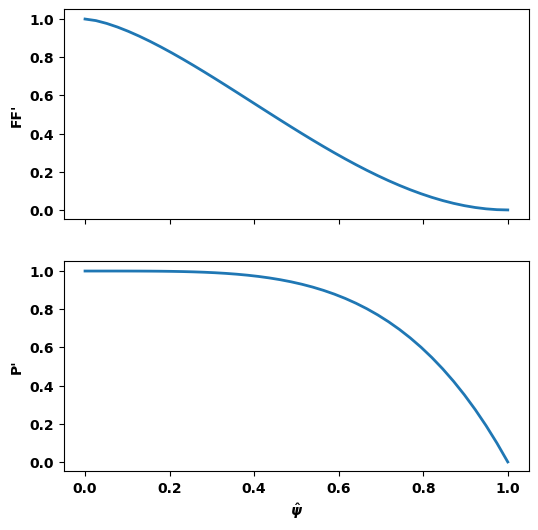

In [11]:
# Set profiles
ffp_prof = create_power_flux_fun(40,1.5,2.0)
pp_prof = create_power_flux_fun(40,4.0,1.0)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [21]:
R0 = 0.28
Z0 = 0.0
a = 0.12
kappa = 1.2
delta = 0.05
err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)
err_flag = mygs.solve()

Starting non-linear GS solver
 DGETRF           1
 Timing:   1.7819715005316539E-002
   Source:     6.8886299777659588E-004
   Solve:      1.4981553002144210E-002
   Boundary:   0.0000000000000000     
   Other:      2.1492990053957328E-003


there is an error with some matrix multiplication 

ValueError: zero-size array to reduction operation maximum which has no identity

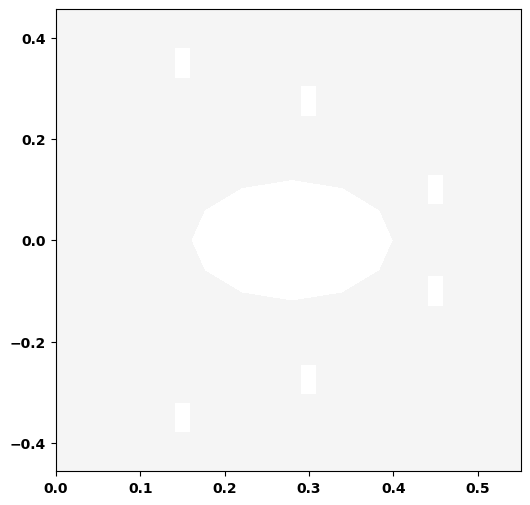

In [22]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.0E-3,coil_clabel=r'$I_{coil}$ [kA]')
mygs.plot_psi(fig,ax,xpoint_color='k',vacuum_nlevels=8)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='.')

In [23]:
mygs.print_info()
 
print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E3))

 DLSODE-  At T (=R1) and step size H (=R2), the                                  
       corrector convergence failed repeatedly                                   
       or with ABS(H) = HMIN                                                     
      In above,  R1 =  0.0000000000000D+00   R2 =  0.2396844981071D-04
           1  0.45050000000000001        0.0000000000000000        0.0000000000000000     
 DLSODE-  At T (=R1) and step size H (=R2), the                                  
       corrector convergence failed repeatedly                                   
       or with ABS(H) = HMIN                                                     
      In above,  R1 =  0.0000000000000D+00   R2 =  0.2396844981071D-04
           2  0.45050000000000001        0.0000000000000000        0.0000000000000000     
 DLSODE-  At T (=R1) and step size H (=R2), the                                  
       corrector convergence failed repeatedly                                   
       or with ABS(H

[    0] WARNING: gs_get_qprof: Trace did not complete
[    0] WARNING: gs_get_qprof: Trace did not complete
[    0] WARNING: gs_get_qprof: Trace did not complete


ZeroDivisionError: float division by zero